## Training 
Neural networks are often highly overparameterized, meaning that they have enough capacity to perfectly memorize the training data — even when the labels are random. The surprising result of the training methods of neural networks is that this overparametrization is not a big issue if you use a _good_ optimizer and some additional tricks to prevent overfitting. This is what we are going to discuss in this section.

### SGD

We have now discussed how to derive the gradient of the cross-entropy loss, that we can use to optimize the weights of a neural network by gradient descent. The only problem is that neural networks typically require (comparably) vast amounts of data to learn a suitable feature transformation that is able to discriminate between the classes. The computation of the gradient, which requires to add the gradients of the cross-entropy for each data point is typically too costly if the dataset is big.

**Stochastic Gradient Descent (SGD)** offers here a solution by updating the weights using only a small batch of training examples at a time. That is, in every update step, SGD performs a gradient descent step on the loss function
$$\mathcal{L}(\mathcal{B},\theta)=\frac{1}{\lvert\mathcal{B}\rvert} \sum_{(\vvec{x},y)\in\mathcal{B}} CE(y,f_\theta(\vvec{x})),$$
where $\mathcal{B}\subseteq \mathcal{D}$ is a **batch**. Typically, the batches are chosen as disjunctive subsets of the dataset: $\mathcal{B}_1\cup\ldots\cup\mathcal{B}_m=\mathcal{D}$ and $\mathcal{B}_b\cap \mathcal{B}_j =\emptyset$. Performing the updates on all batches of this disjunctive decomposition is then called an **epoch**.

```{prf:algorithm} SGD

**Input**: training data $\mathcal{D}$, network $f_\theta$, step-size $\eta$
1. Initialize weights $\theta$ randomly
2. **for** epoch $t\in\{1,\ldots,t_{max}\}$
    1. Divide the data into mini-batches $\mathcal{B}_1\cup\ldots\cup\mathcal{B}_m=\mathcal{D}$
    2. **for** each batch $\mathcal{B}$
        1. $\theta\gets \theta -\eta\nabla \mathcal{L}(\mathcal{B},\theta)$
```
Likewise, we can integrate momentum in this optimization scheme, by performing the updates on a batch only.

#### Properties of SGD
SGD is not only more efficient in its computation of the gradients, it also has many theoretical advantages to gradient descent. The computation of the gradients on batches only introduces noise into the gradient descent updates, that are often useful in navigating complex loss landscapes and escaping local minima. 

{numref}`loss_ladscape_fig` gives an impression of the landscape of a neural network with only two parameters. We see how there are multiple local optima and only one very narrow valley that forms the global optimum. SGD can help in these cases, because it's randomness helps to survey the loss landscape without getting stuck in smaller local minima.  

:::{figure} /images/neuralnets/loss_landscape.png
---
height: 320px
name: loss_ladscape_fig
align: center
---
Loss landscape of neural networks for a bi-dimensional parameter space (borrowed from {cite}`li2017visualizing`). There are several local minima and one global minimum.
:::

Generally, sharp minima are considered as less desirable since they are associated with poor generalization (overfitting). Flat minima often generalize better and there are some works that support that these are found with smaller batch sizes (more noisy SGD steps). Due to these properties, SGD is also considered to perform an **implicit regularization**. That is, although the global optimum of the loss would return a vastly overfitting model, SGD is capable to find a minimum that corresponds to a regularizing model. 

However, the randomness of SGD might also be a problem when it comes to the convergence of this method. In fact, SGD requires a decreasing step-size to converge. Hence it requires a learning rate scheduler, and a good learning rate scheduler is in practice often not trivial to find. Additionally, SGD can greatly benefit from additional optimization techniques like momentum.

#### Training with SGD in Pytorch
We have used the Pytorch SGD optimizer already in the previous example, but there we computed gradient descent because we didn't split the data into batches. In order to perform SGD, we load the data into a `DataLoader`. In this example, we set the `batch_size=32`, meaning that each update is performed on 32 randomly sampled examples. The parameter `shuffle=True` reshuffles the dataset in every epoch, such that we get a new split in every epoch.     
We train here a simple shallow network with a single hidden layer of 16 neurons and ReLU activation. When we perform the evaluation to track the loss and accuracy on the train and test-data, we use the command `with torch.no_grad():` to perform the computations without simultaneous gradient tracking.     

Feel free to try playing with the parameters yourself. Note in particular how we need now only 100 epochs to train this simple model, while we needed 1000 gradient descent steps and a multiple-layer network to achieve a similar accuracy.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Generate and preprocess data
X, y = make_moons(n_samples=1000, noise=0.2, random_state=42)
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader for mini-batch SGD
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Define a simple neural network model
model = nn.Sequential(
    nn.Linear(2, 16),
    nn.ReLU(),
    nn.Linear(16, 2)
)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

# Store metrics
train_accs, test_accs = [], []
train_losses, test_losses = [], []

# Training loop
for epoch in range(100):
    model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

    # Evaluate on full train/test sets
    model.eval()
    with torch.no_grad():
        train_outputs = model(X_train)
        test_outputs = model(X_test)

        train_loss = criterion(train_outputs, y_train).item()
        test_loss = criterion(test_outputs, y_test).item()
        train_losses.append(train_loss)
        test_losses.append(test_loss)

        train_preds = train_outputs.argmax(dim=1)
        test_preds = test_outputs.argmax(dim=1)

        train_acc = (train_preds == y_train).float().mean().item()
        test_acc = (test_preds == y_test).float().mean().item()

        train_accs.append(train_acc)
        test_accs.append(test_acc)

# After this, train_accs and test_accs contain accuracy trajectories,
# and train_losses and test_losses contain loss trajectories.


We plot the accuracy and the loss of the training and test data. Quite uncommonly, the test accuracy is here most often higher than the train accuracy. This is usually not the case and due to the low complexity of the data and a test set that probably doesn't contain many points near the decision boundary. We observe the rather noisy progress of the trajectories.

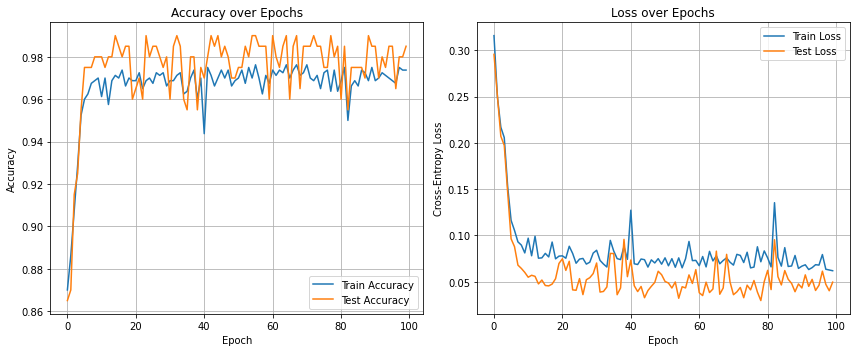

In [2]:
import matplotlib.pyplot as plt

# Plot accuracy and loss side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy plot
ax1.plot(train_accs, label='Train Accuracy')
ax1.plot(test_accs, label='Test Accuracy')
ax1.set_title('Accuracy over Epochs')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Loss plot
ax2.plot(train_losses, label='Train Loss')
ax2.plot(test_losses, label='Test Loss')
ax2.set_title('Loss over Epochs')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Cross-Entropy Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


### Weight Decay
The integration of an $L2$ regularization is integrated into Pytorch's optimizer by the `weight_decay` parameter. Defining the optimizer as    
`optimizer = optim.SGD(model.parameters(), lr=0.1, weight_decay=0.1)`      
adds an $L2$ regularization with regularization weight $\lambda=0.1$. That is, the optimized loss is
$$\mathcal{L}(\mathcal{D},\theta)+\lambda\lVert\theta\rVert^2.$$
Integrating an $L2$ penalization is useful in most applications, since it penalizes big weights and big weights are typically associated with overfitting. You can imagine that the model output is more sensitive to the model input if the weights differ a lot in magnitude. input values that are multiplied with big weights have a bigger variance than input values multiplied with smaller weights.    

Usually, neural network are optimized with a small value of weight decay $\lambda \approx 0.0001$

### Dropout
Dropout is a regularization technique that is also supposed to prevent overfitting in neural networks. During a forward pass, a dropout layer is __dropping out__ (setting to zero) a random subset of the neurons. As a result, the network learns to perform well with a random subset of the nodes, hence reducing dependence on single nodes and being able to deal also with noisy input. The resulting network is supposed to be more robust to small changes in the input. Theoretical works on the effect of dropout suggest that it results in learning weight matrices of low rank. That is, the weight matrices $W=U\Sigma V^\top$ after a dropout layer have an SVD where only few singular values are nonzero.      

The image below visualizes the effect of a dropout layer: two neurons are dropped and their input is not used in the forward pass. 

```{tikz}
\tikzset{%
  every neuron/.style={
    circle,
    draw,
    minimum size=0.5cm
  },
}

\begin{tikzpicture}[x=1.5cm, y=1cm, >=stealth]

% Create input nodes
\foreach \m/\l [count=\y] in {1,2,3,4,5,6}
  \node [every neuron/.try, neuron \m/.try] (input-\m) at (0,2.5-\y) {};

% add cross to dropout nodes
\draw[-] ($(input-3.center)+(-0.2,-0.2)$) -- ($(input-3.center)+(0.2,0.2)$);
\draw[-] ($(input-3.center)+(-0.2,0.2)$) -- ($(input-3.center)+(0.2,-0.2)$);
\draw[-] ($(input-5.center)+(-0.2,-0.2)$) -- ($(input-5.center)+(0.2,0.2)$);
\draw[-] ($(input-5.center)+(-0.2,0.2)$) -- ($(input-5.center)+(0.2,-0.2)$);


% Create output layer nodes
\foreach \m [count=\y] in {1,2,3,4}
  \node [every neuron/.try, neuron \m/.try ] (output-\m) at (2,1.8-\y) {};

\foreach \l [count=\i] in {1,2,3,4,5,6}
  \draw [<-] (input-\i) -- ++(-0.7,0)
    node [above, midway] {$h^{(\ell)}_\l$};

%Connect input to output layer
\foreach \i in {1,2,4,6}
  \foreach \j in {1,2,3,4}
    \draw [->] (input-\i) -- (output-\j);
    

\end{tikzpicture}
```

The pseudocode below details how a dropout layer works. 
```{prf:algorithm}  Dropout layer
**Input**: the output of the previous hidden layer $\vvec{h}^{(\ell)}$ with dimensionality $d_{\ell}$, the probability of dropout $p$
1. **if** not `training`
    1. **return** $\vvec{h}^{(\ell)}$
2. Sample $\vvec{u}\sim\mathcal{U}([0,1])^{d_\ell}$
3. $1_u \gets \vvec{u}>p$
4. **return** $\frac{1}{1-p} 1_u\circ\vvec{h}^{(\ell)} $ #element-wise product
```
Maybe a bit surprisingly, dropout doesn't just deactivate neurons, but it also scales the output with $\frac{1}{1-p}$. The reason for that is to keep the expected value of the output of a neuron the same with dropout. Let $\mathrm{dropout}(x)$ be the dropout output of hidden layer neuron $x$, then we drop the neuron with probability $p$ and keep it with probability $1-p$. If we keep it, then the output is $\frac{x}{1-p}$. Hence, the expected value of this neuron after dropout is
\begin{align*}
\mathbb{E}[\mathrm{dropout}(x)] = 0\cdot p + \frac{x}{1-p}\cdot (1-p) = x
\end{align*}
In Pytorch, we keep track of whether the model is trained or not by setting either `model.train()` or `model.eval()`. In evaluation mode, the dropout layer is letting through the input and the network acts deterministic. In training mode, the dropout layer is on and the model output is not deterministic.

In [3]:
import torch
import torch.nn as nn

class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(10, 10)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(10, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)

model = SimpleNet()
x = torch.ones(1, 10)

with torch.no_grad():
    # During training: dropout is active
    model.train()
    y_train = model(x)
    print("Output 1 with dropout (train mode):", y_train)
    # During training: dropout is active
    y_train = model(x)
    print("Output 2 with dropout (train mode):", y_train)

    # During evaluation: dropout is disabled
    model.eval()
    y_eval = model(x)
    print("Output 1 without dropout (eval mode):", y_eval)
    # During evaluation: dropout is disabled
    y_eval = model(x)
    print("Output 2 without dropout (eval mode):", y_eval)

Output 1 with dropout (train mode): tensor([[-0.8045]])
Output 2 with dropout (train mode): tensor([[-0.4288]])
Output 1 without dropout (eval mode): tensor([[-0.4461]])
Output 2 without dropout (eval mode): tensor([[-0.4461]])
